# IMdB Movies

## Importing libraries

In [861]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from random import gauss, seed
from scipy import stats
import seaborn as sns
from mpl_toolkits import mplot3d
import sklearn.metrics as metrics
import statsmodels.api as sm
import warnings
import sqlite3
warnings.filterwarnings("ignore")

%matplotlib inline

## Load datasets

In [862]:
movie_budgets = pd.read_csv('../zippedData/tn.movie_budgets.csv.gz')
movies = pd.read_csv('../zippedData/tmdb.movies.csv.gz')
reviews = pd.read_csv('../zippedData/rt.reviews.tsv.gz', sep = '\t', encoding = 'latin1')
movie_info = pd.read_csv('../zippedData/rt.movie_info.tsv.gz', sep = '\t', encoding = 'latin1')
movie_gross = pd.read_csv('../zippedData/bom.movie_gross.csv.gz')

## Data Cleaning

### Cleaning Movie Budgets Dataset

In [863]:
# Cleaning and Formatting the 'production_budget' Column in the 'movie_budgets' DataFrame
movie_budgets['production_budget'] = movie_budgets['production_budget'].map(lambda x: x.replace("$", "").replace(",", ""))
movie_budgets['production_budget'] = movie_budgets['production_budget'].map(lambda x: float(x))

In [864]:
# Cleaning and Formatting the 'domestic_gross' Column in the 'movie_budgets' DataFrame
movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].map(lambda x: x.replace("$", "").replace(",", ""))
movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].map(lambda x: float(x))

In [865]:
# Cleaning and Formatting the 'worldwide_gross' Column in the 'movie_budgets' DataFrame
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].map(lambda x: x.replace("$", "").replace(",", ""))
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].map(lambda x: float(x))

In [866]:
# Converting 'release_date' to datetime formatmovie_budgets
movie_budgets['release_date'] = pd.to_datetime(movie_budgets['release_date'], format='%b %d, %Y')

In [867]:
# Calculating ROI for Movies
movie_budgets['ROI'] = ((movie_budgets['worldwide_gross'] - movie_budgets['production_budget'])/movie_budgets['production_budget'])

### Cleaning Movie Info Dataset

In [868]:
# Creating Genre Lists from Genre Column in Movie Info DataFrame
movie_info['genre'] = movie_info['genre'].apply(lambda x: str(x))
movie_info['genre_list'] = movie_info['genre'].apply(lambda x: x.split('|'))

In [869]:
movie_info.drop('genre', axis=1, inplace=True)

In [870]:
# Converting Theater Date Column to Datetime in Movie Info DataFrame
movie_info['theater_date'] = pd.to_datetime(movie_info['theater_date'], format='%b %d, %Y')

In [871]:
# Cleaning and Converting Runtime Column in Movie Info DataFrame
movie_info['runtime'] = movie_info['runtime'].str.replace("minutes", "")
movie_info['runtime'] = movie_info['runtime'].map(lambda x: float(x))

In [872]:
# Converting Columns to Strings in Movie Info DataFrame
movie_info['director'] = movie_info['director'].map(lambda x: str(x))
movie_info['studio'] = movie_info['studio'].map(lambda x: str(x))

In [873]:
# Cleaning Box Office Column in Movie Info DataFrame
movie_info['box_office'] = movie_info['box_office'].str.replace('$', '')
movie_info['box_office'] = movie_info['box_office'].str.replace(',', '')

In [874]:
movie_info['box_office'] = movie_info['box_office'].map(lambda x: float(x))

In [875]:
# Dropping Rows with Missing Box Office Data in Movie Info DataFrame
movie_info.dropna(subset=['box_office'], inplace=True)

## SQL Data Calling

### Connecting to SQLite Database

In [876]:
con = sqlite3.connect('../zippedData/im.db')

### Fetching Database Schema Information

In [877]:
master = pd.read_sql("""
SELECT *
FROM sqlite_master
;""", con)
master

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [878]:
tables = list(master['name'])
tables

['movie_basics',
 'directors',
 'known_for',
 'movie_akas',
 'movie_ratings',
 'persons',
 'principals',
 'writers']

In [879]:
movie_basics = pd.read_sql("""
SELECT *
FROM movie_basics
;""", con)
movie_basics

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


In [880]:
directors = pd.read_sql("""
SELECT *
FROM directors
;""", con)

In [881]:
known_for = pd.read_sql("""
SELECT *
FROM known_for
;""", con)

In [882]:
movie_akas = pd.read_sql("""
SELECT *
FROM movie_akas
;""", con)
movie_akas

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.0
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.0
...,...,...,...,...,...,...,...,...
331698,tt9827784,2,Sayonara kuchibiru,None,None,original,None,1.0
331699,tt9827784,3,Farewell Song,XWW,en,imdbDisplay,None,0.0
331700,tt9880178,1,La atención,None,None,original,None,1.0
331701,tt9880178,2,La atención,ES,None,None,None,0.0


In [883]:
movie_ratings = pd.read_sql("""
SELECT *
FROM movie_ratings
;""", con)
movie_ratings

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
...,...,...,...
73851,tt9805820,8.1,25
73852,tt9844256,7.5,24
73853,tt9851050,4.7,14
73854,tt9886934,7.0,5


In [884]:
persons = pd.read_sql("""
SELECT *
FROM persons
;""", con)
persons

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"
...,...,...,...,...,...
606643,nm9990381,Susan Grobes,NaN,NaN,actress
606644,nm9990690,Joo Yeon So,NaN,NaN,actress
606645,nm9991320,Madeline Smith,NaN,NaN,actress
606646,nm9991786,Michelle Modigliani,NaN,NaN,producer


In [885]:
principals = pd.read_sql("""
SELECT *
FROM principals
;""", con)
principals

,movie_id,ordering,person_id,category,job,characters
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]"
1,tt0111414,2,nm0398271,director,None,None
2,tt0111414,3,nm3739909,producer,producer,None
3,tt0323808,10,nm0059247,editor,None,None
4,tt0323808,1,nm3579312,actress,None,"[""Beth Boothby""]"
...,...,...,...,...,...,...
1028181,tt9692684,1,nm0186469,actor,None,"[""Ebenezer Scrooge""]"
1028182,tt9692684,2,nm4929530,self,None,"[""Herself"",""Regan""]"
1028183,tt9692684,3,nm10441594,director,None,None
1028184,tt9692684,4,nm6009913,writer,writer,None


In [886]:
writers = pd.read_sql("""
SELECT *
FROM writers
;""", con)
writers

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0438973,nm0175726
2,tt0438973,nm1802864
3,tt0462036,nm1940585
4,tt0835418,nm0310087
...,...,...
255868,tt8999892,nm10122246
255869,tt8999974,nm10122357
255870,tt9001390,nm6711477
255871,tt9004986,nm4993825


### Merging Datasets

In [887]:
# Merging Data from Multiple Tables in the SQLite Database
merged_sql = pd.read_sql("""
SELECT b.primary_title, b.runtime_minutes AS runtime, b.genres AS genres, 
r.averagerating, r.numvotes, p.category AS staff_role, ps.primary_name AS staff_name
FROM movie_basics AS b
JOIN movie_ratings AS r
    USING(movie_id)
JOIN principals AS p
    USING(movie_id)
JOIN persons AS ps
    USING(person_id)
;""", con)
merged_sql

,primary_title,runtime,genres,averagerating,numvotes,staff_role,staff_name
0,Sunghursh,175.0,"Action,Crime,Drama",7.0,77,composer,Naushad
1,Sunghursh,175.0,"Action,Crime,Drama",7.0,77,writer,Abrar Alvi
2,Sunghursh,175.0,"Action,Crime,Drama",7.0,77,writer,Gulzar
3,Sunghursh,175.0,"Action,Crime,Drama",7.0,77,actor,Dilip Kumar
4,Sunghursh,175.0,"Action,Crime,Drama",7.0,77,actor,Sanjeev Kumar
...,...,...,...,...,...,...,...
629593,Drømmeland,72.0,Documentary,6.5,11,editor,Tom Denoyette
629594,Drømmeland,72.0,Documentary,6.5,11,composer,Tobias Borkert
629595,Drømmeland,72.0,Documentary,6.5,11,director,Joost van der Wiel
629596,Drømmeland,72.0,Documentary,6.5,11,self,Nils Leidal


In [888]:
# Splitting the 'Genres' Column into Lists of Genres in the Merged DataFrame
merged_sql['genres'] = merged_sql['genres'].str.split(',')

In [889]:
# Merging Movie Budgets and Genres DataFrames on Movie Titles (Inner Join)
movies_budget_genres = pd.merge(movie_budgets, merged_sql, left_on='movie', right_on = 'primary_title', how='inner')

In [890]:
# Merging Movie Budgets and Movie Details DataFrames on Movie Titles (Inner Join)
movies_budget_merge = pd.merge(movie_budgets, movies, left_on='movie', right_on = 'original_title', how='inner')

In [891]:
movies_budget_merge.drop(['id_x', 'release_date_x'], axis = 1, inplace = True)

In [892]:
# Renaming Columns in Merged Movie Budgets and Movie Details DataFrame
movies_budget_merge.rename(columns={'id_y': 'id', 'release_date_y': 'release_date'}, inplace=True)
movies_budget_merge

,movie,production_budget,domestic_gross,worldwide_gross,ROI,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,Avatar,425000000.0,760507625.0,2.776345e+09,5.532577,6,"[28, 12, 14, 878]",19995,en,Avatar,26.526,2009-12-18,Avatar,7.4,18676
1,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,1.546673,2470,"[12, 28, 14]",1865,en,Pirates of the Caribbean: On Stranger Tides,30.579,2011-05-20,Pirates of the Caribbean: On Stranger Tides,6.4,8571
2,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,3.243841,14169,"[28, 12, 878]",99861,en,Avengers: Age of Ultron,44.383,2015-05-01,Avengers: Age of Ultron,7.3,13457
3,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,5.827114,23811,"[12, 28, 14]",299536,en,Avengers: Infinity War,80.773,2018-04-27,Avengers: Infinity War,8.3,13948
4,Justice League,300000000.0,229024295.0,6.559452e+08,1.186484,20623,"[28, 12, 14, 878]",141052,en,Justice League,34.953,2017-11-17,Justice League,6.2,7510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2311,Exeter,25000.0,0.0,4.897920e+05,18.591680,14678,"[53, 27]",226458,en,Exeter,5.934,2015-03-26,Exeter,4.7,121
2312,Ten,25000.0,0.0,0.000000e+00,-1.000000,12326,"[12, 27, 9648, 53]",279516,en,Ten,1.575,2014-03-28,Ten,5.4,5
2313,Dry Spell,22000.0,0.0,0.000000e+00,-1.000000,10470,"[35, 10749]",255266,en,Dry Spell,0.600,2013-02-14,Dry Spell,6.0,1
2314,All Superheroes Must Die,20000.0,0.0,0.000000e+00,-1.000000,8893,"[878, 53]",86304,en,All Superheroes Must Die,2.078,2013-01-04,All Superheroes Must Die,3.9,19


## More Data Cleaning

### Filtering DataSet

In [982]:
# Filtering Movies: Ratings Above 7, Votes Exceeding 1,000, and ROI Greater Than 10%
sorted_budgets = sorted_budgets.sort_values(by = 'ROI', ascending = False)
sorted_budgets = sorted_budgets[(sorted_budgets['averagerating'] > 7) & (sorted_budgets['numvotes'] > 1000) & (sorted_budgets['ROI'] > 10)]
sorted_budgets

,movie,release_date,production_budget,domestic_gross,worldwide_gross,ROI,runtime,genres,averagerating,numvotes,release_month,budget_category
643,Get Out,2017-02-24,5000000.0,176040665.0,255367951.0,50.073590,104.000000,"[Horror, Mystery, Thriller]",7.700000,400474.000000,February,$5M-$20M
1052,Moonlight,2016-10-21,1500000.0,27854931.0,65245512.0,42.497008,111.000000,[Drama],7.400000,227964.000000,October,<$5M
1625,The Fault in Our Stars,2014-06-06,12000000.0,124872350.0,307166834.0,24.597236,126.000000,"[Drama, Romance]",7.700000,315135.000000,June,$5M-$20M
245,Black Swan,2010-12-03,13000000.0,106954678.0,331266710.0,24.482055,108.000000,"[Drama, Thriller]",8.000000,648854.000000,December,$5M-$20M
232,Billy Elliot,2000-10-13,5000000.0,21995263.0,109253745.0,20.850749,169.000000,"[Comedy, Drama, Music]",8.500000,1109.000000,October,$5M-$20M
1,10 Cloverfield Lane,2016-03-11,5000000.0,72082999.0,108286422.0,20.657284,103.000000,"[Drama, Horror, Mystery]",7.200000,260383.000000,March,$5M-$20M
916,La La Land,2016-12-09,20000000.0,151101803.0,426351163.0,20.317558,128.000000,"[Comedy, Drama, Music]",8.000000,436070.000000,December,$20M-$50M
834,It,2017-09-08,35000000.0,327481748.0,697457969.0,18.927371,135.000000,"[Horror, Thriller]",7.400000,359123.000000,September,$20M-$50M
46,A Quiet Place,2018-04-06,17000000.0,188024361.0,334522294.0,18.677782,85.882353,[Documentary],7.188235,179437.411765,April,$5M-$20M
628,Fruitvale Station,2013-07-12,900000.0,16098998.0,17549645.0,18.499606,85.000000,"[Biography, Drama, Romance]",7.500000,68187.000000,July,<$5M


###  Average ROI by Release Month

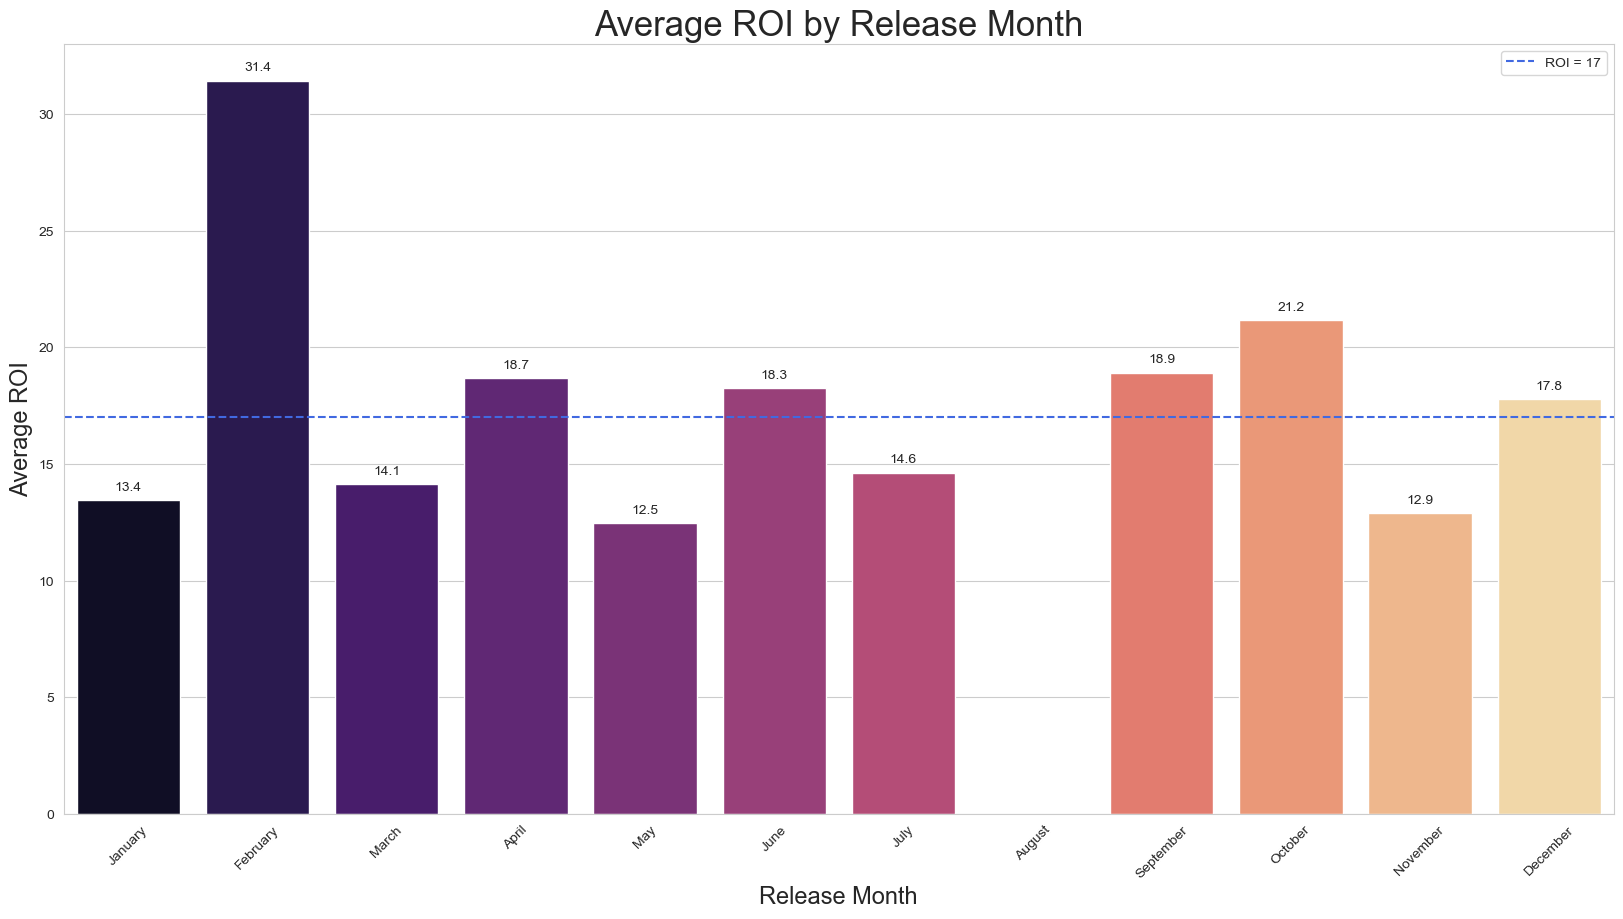

In [895]:
# Vizualization: Average ROI by Release Month
import calendar

sorted_budgets['release_month'] = sorted_budgets['release_date'].dt.month.apply(lambda x: calendar.month_name[x])

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(20, 10))
bars = sns.barplot(x='release_month', y='ROI', data=sorted_budgets, palette='magma', order=month_order, ci=None)

for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.1f'), 
                   (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                   ha='center', va='center',
                   xytext=(0, 9), 
                   textcoords='offset points')

plt.axhline(17, color='royalblue', linestyle='--', label='ROI = 17')

plt.title('Average ROI by Release Month', fontsize=25)
plt.xlabel('Release Month', fontsize=17)
plt.ylabel('Average ROI', fontsize=17)
plt.xticks(rotation=45)
plt.legend()

plt.show()


###  Average ROI by Movie Genres

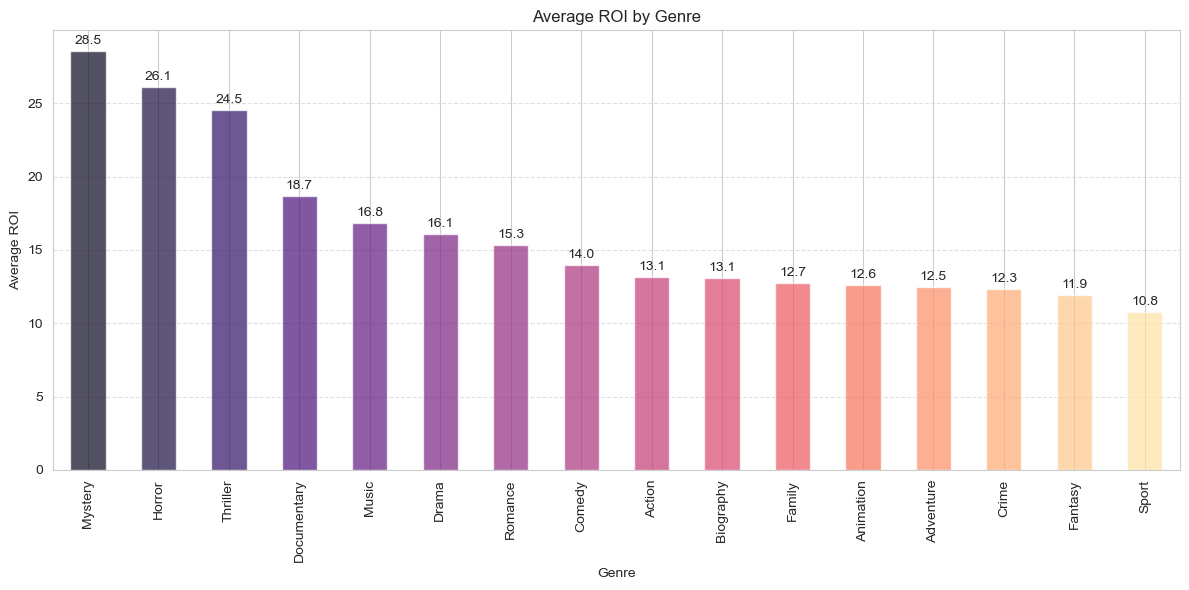

In [896]:
# Relationship between movie genres and their average ROI values.
exploded_df = sorted_budgets.explode('genres')
genre_roi = exploded_df.groupby('genres')['ROI'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
colors = sns.color_palette('magma', n_colors=len(genre_roi))
bars = genre_roi.plot(kind='bar', color=colors, alpha=0.7)

for idx, value in enumerate(genre_roi):
    plt.annotate(f'{value:.1f}', 
                 (idx, value), 
                 textcoords="offset points", 
                 xytext=(0,5),  
                 ha='center')  

plt.title('Average ROI by Genre')
plt.xlabel('Genre')
plt.ylabel('Average ROI')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()


###  Average ROI by Distribution of Movie Runtimes

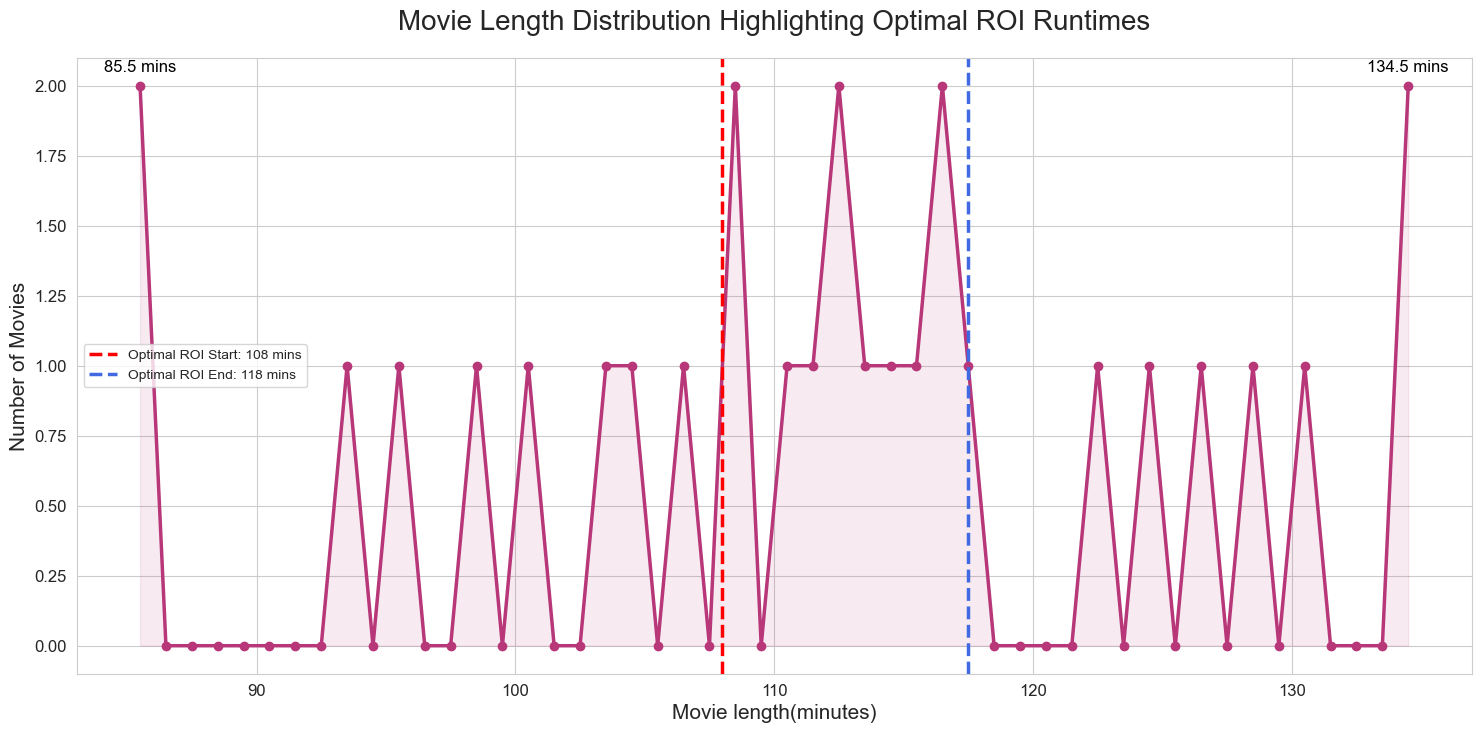

In [983]:
# Histogram with Distribution of Movie Runtimes

plt.figure(figsize=(18, 8))

plt.plot(bin_centers, counts, color=color, marker='o', linestyle='-', linewidth=2.5, markersize=6)
plt.fill_between(bin_centers, counts, color=color, alpha=0.1)

highlight_start = 108
highlight_end = 117.5
plt.axvline(highlight_start, color='red', linestyle='--', linewidth=2.5, label="Optimal ROI Start: 108 mins")
plt.axvline(highlight_end, color='royalblue', linestyle='--', linewidth=2.5, label="Optimal ROI End: 118 mins")

target_runtimes = [bin_centers[0], 134.5]
for runtime in target_runtimes:
    count_at_runtime = counts[np.abs(bin_centers - runtime).argmin()]
    plt.annotate(f"{runtime:.1f} mins", 
                 (runtime, count_at_runtime), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center', 
                 fontsize=12,
                 color='black')

plt.title('Movie Length Distribution Highlighting Optimal ROI Runtimes', fontsize=20, pad=20)
plt.xlabel('Movie length(minutes)', fontsize=15)
plt.ylabel('Number of Movies', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()

plt.show()

### Relationships between Average ROI and Production Budget

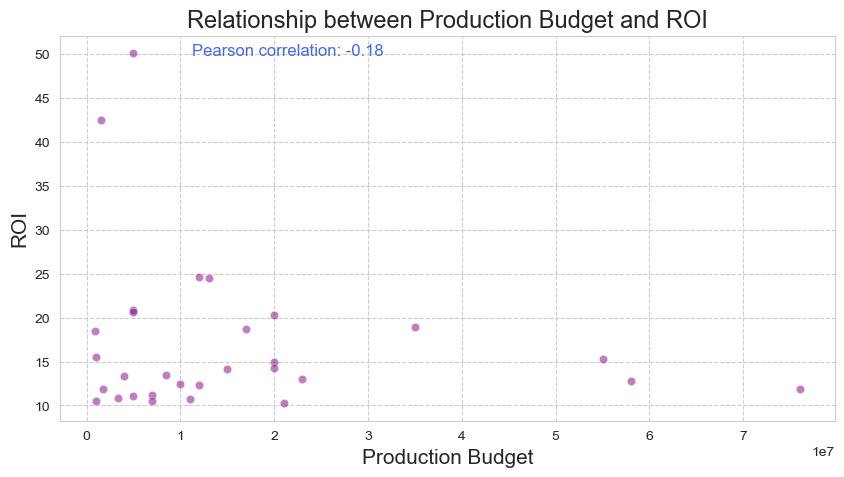

In [943]:
# Displaying the Pearson correlation coefficient and Relationship between Production Budget and ROI
plt.figure(figsize=(10, 5))
sns.scatterplot(data=sorted_budgets, x='production_budget', y='ROI', alpha=0.5, color='purple')

plt.title('Relationship between Production Budget and ROI', fontsize=17)
plt.xlabel('Production Budget', fontsize=15)
plt.ylabel('ROI', fontsize=15)
plt.grid(True, which="both", linestyle="--")

correlation = np.corrcoef(sorted_budgets['production_budget'], sorted_budgets['ROI'])[0, 1]
plt.annotate(f'Pearson correlation: {correlation:.2f}', 
             xy=(0.17, 0.95), 
             xycoords='axes fraction', 
             fontsize=12, 
             color='royalblue')

plt.show()

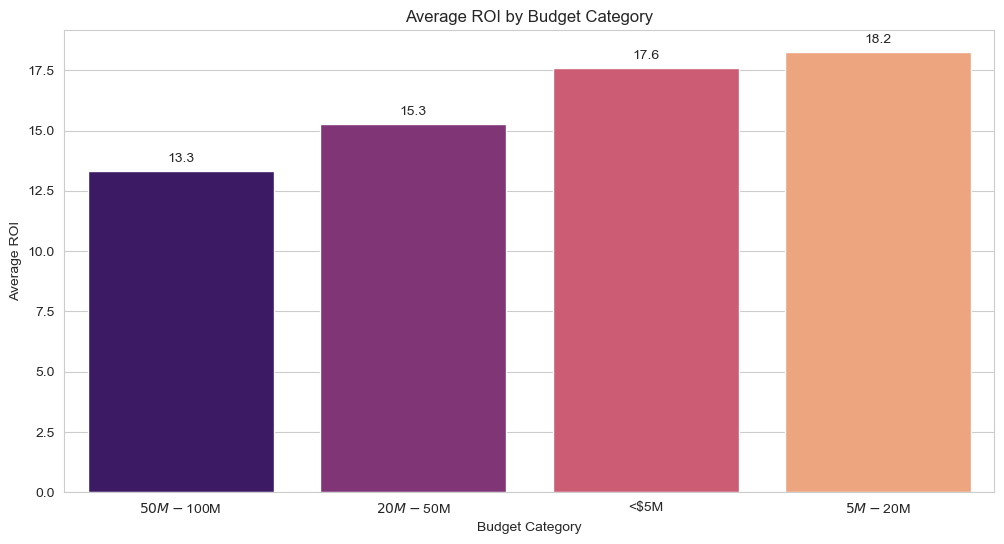

In [899]:
# Displaying Average ROI by Budget Category
plt.figure(figsize=(12, 6))
bars = sns.barplot(x=avg_roi.index, y=avg_roi.values, palette='magma')

for bar in bars.patches:
    bars.annotate(format(bar.get_height(), '.1f'), 
                  (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                  ha='center', va='center',
                  xytext=(0, 9), 
                  textcoords='offset points')

plt.title('Average ROI by Budget Category')
plt.ylabel('Average ROI')
plt.xlabel('Budget Category')
plt.show()

In [985]:
# Calculating and Sorting Average ROI by Staff Role
sorted_staff = movies_budget_genres.groupby('staff_role')
sorted_staff = sorted_staff['ROI'].mean()
sorted_staff

staff_role
actor                  2.716018
actress                3.668201
archive_footage        1.120821
archive_sound          1.526178
cinematographer        3.075224
composer               3.035291
director               3.172099
editor                 3.567231
producer               3.299064
production_designer    2.650520
self                   1.875599
writer                 2.858757
Name: ROI, dtype: float64

In [987]:
# Filtering movies_budget_merge df
sorted_movies = movies_budget_merge.sort_values(by='ROI', ascending=False)
sorted_movies = sorted_movies[(sorted_movies['vote_average'] > 7) & (sorted_movies['vote_count'] > 1000) & (sorted_movies['ROI'] > 10)]
sorted_movies

,movie,production_budget,domestic_gross,worldwide_gross,ROI,Unnamed: 0,genre_ids,id,original_language,popularity,release_date,vote_average,vote_count
2088,Saw,1200000.0,55968727.0,103880027.0,85.566689,11055,"[27, 9648, 80]",176,en,19.127,2004-10-29,7.4,4795
1720,Split,5000000.0,138141585.0,278964806.0,54.792961,17393,"[27, 53]",381288,en,25.783,2016-09-26,7.2,10375
1718,Get Out,5000000.0,176040665.0,255367951.0,50.073590,20637,"[9648, 53, 27]",419430,en,24.739,2017-02-24,7.5,8760
2053,Moonlight,1500000.0,27854931.0,65245512.0,42.497008,17447,[18],376867,en,15.948,2016-10-21,7.4,3893
2054,Moonlight,1500000.0,27854931.0,65245512.0,42.497008,20691,[18],376867,en,15.948,2016-10-21,7.4,3893
115,Beauty and the Beast,20000000.0,376057266.0,608431132.0,29.421557,5181,"[10749, 10751, 16, 14]",10020,en,26.701,2012-01-13,7.7,5730
1385,The Fault in Our Stars,12000000.0,124872350.0,307166834.0,24.597236,11072,"[10749, 18]",222935,en,16.030,2014-05-16,7.6,7236
1354,Black Swan,13000000.0,106954678.0,331266710.0,24.482055,47,"[18, 53]",44214,en,13.745,2010-12-03,7.6,8374
1454,Good Will Hunting,10000000.0,138433435.0,225925989.0,21.592599,2485,[18],489,en,18.013,1997-12-05,8.1,5764
1095,La La Land,20000000.0,151101803.0,426351163.0,20.317558,20688,"[35, 18, 10749]",313369,en,16.275,2016-12-09,7.9,10028


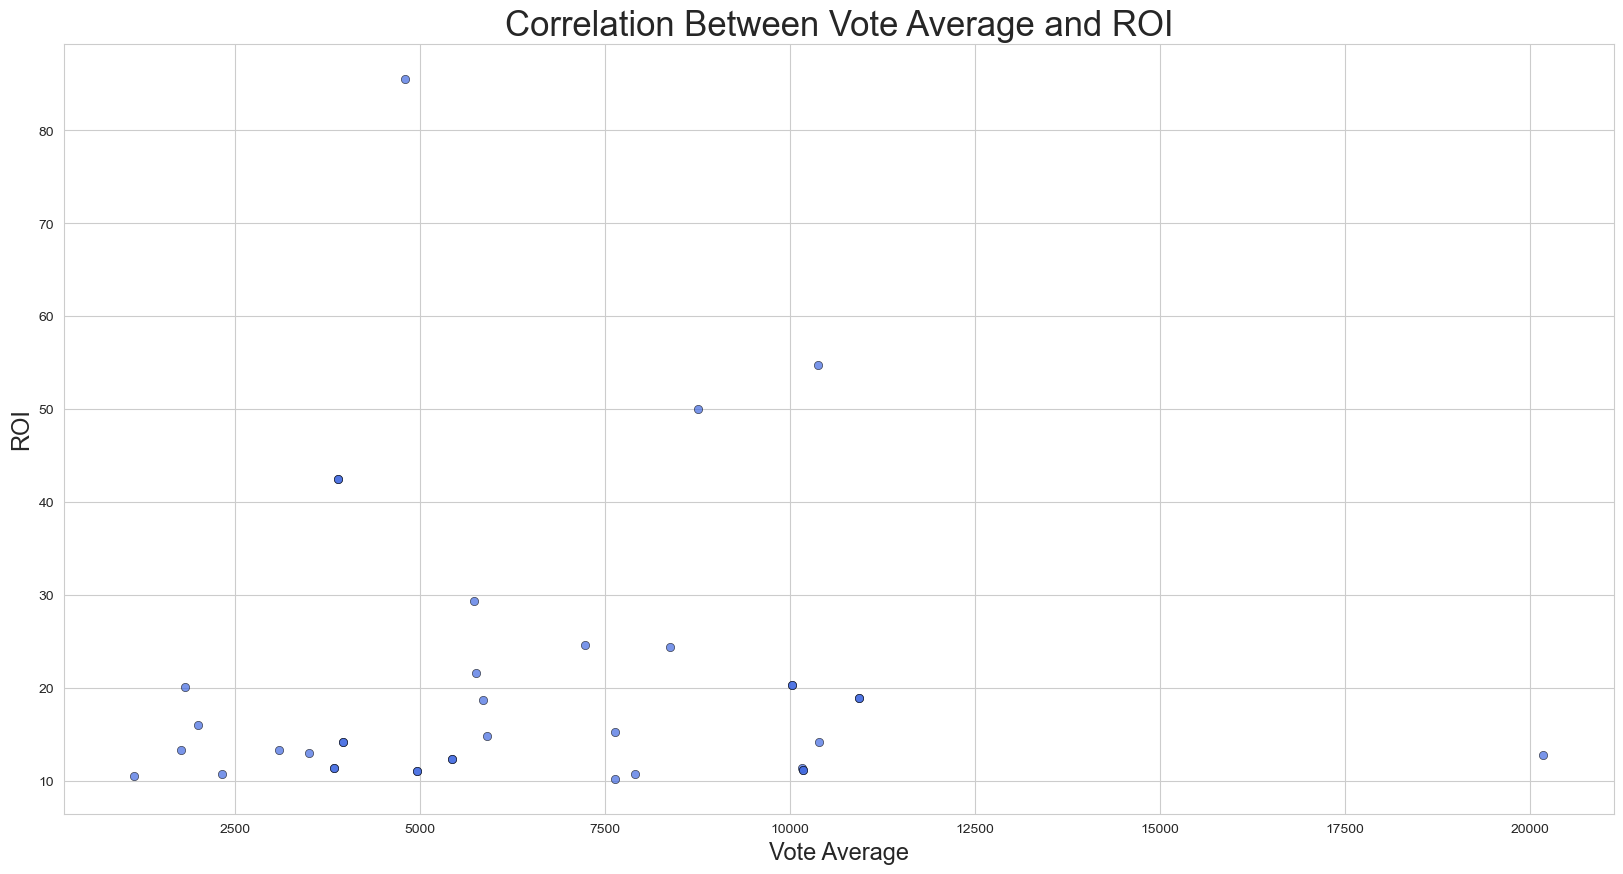

In [988]:
# Create a scatter plot to visualize the correlation Between Vote Average and ROI
filtered_movies = sorted_movies[sorted_movies['vote_count'] >= 500]

plt.figure(figsize=(20, 10))
sns.scatterplot(data=filtered_movies, x='vote_count', y='ROI', alpha=0.7, color='royalblue', edgecolor='black')
plt.title('Correlation Between Vote Average and ROI', fontsize=25)
plt.xlabel('Vote Average', fontsize=17)
plt.ylabel('ROI', fontsize=17)
plt.grid(True)
plt.show()

In [989]:
sorted_by_rating = movie_info.sort_values(by='box_office', ascending=False)
sorted_by_rating.head(20)

,id,synopsis,rating,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,genre_list
827,1071,This depiction of the last 12 hours in the lif...,R,Mel Gibson,Mel Gibson|Benedict Fitzgerald,2004-02-25,"Aug 31, 2004",$,368000000.0,127.0,Newmarket Film Group,[Drama]
877,1136,The Hobbit: An Unexpected Journey follows titl...,PG-13,Peter Jackson,Peter Jackson|Philippa Boyens|Guillermo del To...,2012-12-14,"Mar 19, 2013",$,303001229.0,170.0,Warner Bros.,"[Action and Adventure, Science Fiction and Fan..."
1188,1525,"In Skyfall, Bond's loyalty to M is tested as h...",PG-13,Sam Mendes,John Logan|Robert Wade|Neal Purvis,2012-11-09,"Mar 11, 2013",$,299300000.0,145.0,MGM,"[Action and Adventure, Mystery and Suspense]"
690,883,"Now that Greg Focker is ""in"" with his soon-to-...",PG-13,Jay Roach,Jim Herzfeld|John Hamburg,2004-12-22,"Apr 26, 2005",$,279167575.0,118.0,Universal Pictures,[Comedy]
1117,1442,Youthful wizard Harry Potter returns to the sc...,PG,Chris Columbus,Steve Kloves,2002-11-15,"Apr 11, 2003",$,261835892.0,161.0,Warner Bros. Pictures,"[Kids and Family, Science Fiction and Fantasy]"
966,1255,Mission: Impossible III director and Alias cre...,PG-13,nan,Gene Roddenberry|Alex Kurtzman|Roberto Orci,2009-05-07,"Nov 17, 2009",$,257704099.0,127.0,IMAX,"[Action and Adventure, Drama, Science Fiction ..."
504,661,One woman's rocky road to the altar gets playe...,PG,Joel Zwick,Nia Vardalos,2002-04-19,"Feb 11, 2003",$,241250669.0,95.0,IFC Films,"[Comedy, Romance]"
657,841,This is a contemporary retelling of H.G. Wells...,PG-13,Steven Spielberg,Josh Friedman|David Koepp,2005-06-29,"Nov 22, 2005",$,234141872.0,117.0,Paramount Pictures,"[Action and Adventure, Science Fiction and Fan..."
1458,1877,A hard-drinking lush finds himself thrust into...,PG-13,Peter Berg,Vincent Gilligan|Vince Gilligan|Vy Vincent Ngo,2008-06-16,"Nov 25, 2008",$,227946274.0,92.0,Columbia Pictures,"[Action and Adventure, Comedy, Drama]"
1237,1600,When a failed assassination attempt occurs on ...,PG-13,Bryan Singer,Daniel Harris|Dan Harris|Michael Dougherty|Bry...,2003-05-02,"Nov 25, 2003",$,214813155.0,134.0,20th Century Fox,"[Action and Adventure, Science Fiction and Fan..."


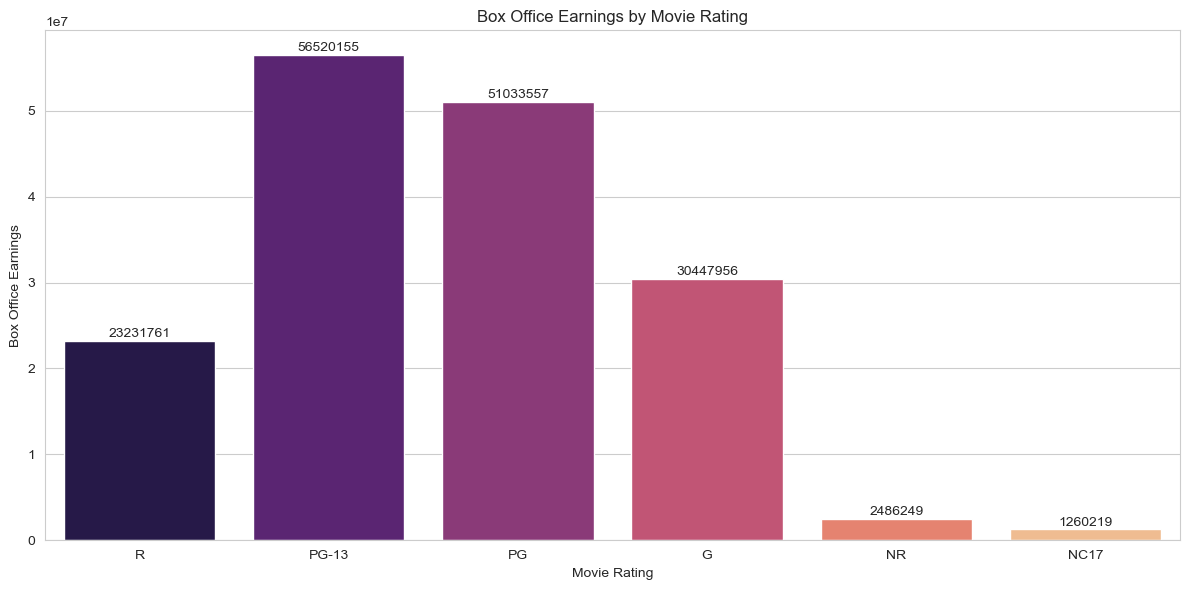

In [990]:
# Vizualizing Box Office Earnings by Movie Rating
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x='rating', y='box_office', data=sorted_by_rating, palette='magma', ci=None)

for bar in plt.gca().patches:
    plt.gca().annotate('{:.0f}'.format(bar.get_height()), 
                       (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                       ha='center', va='center', 
                       xytext=(0, 5), 
                       textcoords='offset points')

plt.title('Box Office Earnings by Movie Rating')
plt.xlabel('Movie Rating')
plt.ylabel('Box Office Earnings')
plt.tight_layout()
plt.show()

In [997]:
top_directors = sorted_by_rating['director'].value_counts()
top_directors = top_directors[top_directors.index.notnull()].head(10)
top_directors

director
nan                41
Clint Eastwood      4
Lawrence Kasdan     2
Neil Jordan         2
Kasi Lemmons        2
Seth MacFarlane     2
Julian Jarrold      2
Ang Lee             2
Trish Sie           2
Donald Petrie       2
Name: count, dtype: int64

In [998]:
top_writers = sorted_by_rating['writer'].value_counts()
top_writers = top_writers[top_writers.index.notnull()].head(10)
top_writers

writer
Edward Burns|Scott Frank                      2
Peter Morgan                                  2
Mike White                                    2
Seth MacFarlane|Alec Sulkin|Wellesley Wild    2
Mel Gibson|Benedict Fitzgerald                1
Francis Veber                                 1
Derek Connolly                                1
Jane Campion                                  1
Michael Genet|Rick Famuyiwa                   1
Hamish McColl|Jimmy Perry                     1
Name: count, dtype: int64